<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

Dask Arrays on a Cluster
===================

With meteorological data from ECMWF

<img src="https://bids.berkeley.edu/sites/default/files/styles/400x225/public/projects/numpy_project_page.jpg?itok=flrdydei"
    align="left"
    width="30%"
    alt="NumPy Logo">

### Load weather data from S3

In [1]:
from dask.distributed import Executor, progress
e = Executor('localhost:8786')
e

<Executor: scheduler=localhost:8786 processes=88 cores=88>

In [2]:
from s3fs import S3Map
dc = S3Map('dask-zarr-data/ecmwf/compressed/2014/t2m')

from zarr import Array
z = Array(store=dc)

In [3]:
import dask.array as da
x = da.from_array(z, chunks=z.chunks)
x

dask.array<from-ar..., shape=(1460, 721, 1440), dtype=float64, chunksize=(4, 721, 1440)>

In [4]:
x = e.persist(x)
progress(x)

In [5]:
da.set_options(get=e.get)  # Use cluster by default

### Simple computations

In [6]:
x[0, :5, :5].compute()

array([[ 253.96238624,  253.96238624,  253.96238624,  253.96238624,
         253.96238624],
       [ 252.80590921,  252.81070124,  252.81389593,  252.82028531,
         252.82348   ],
       [ 252.57908637,  252.58547575,  252.59186512,  252.59505981,
         252.60144919],
       [ 252.69090045,  252.69569248,  252.70048451,  252.70527654,
         252.71006857],
       [ 252.29156446,  252.29635649,  252.30434321,  252.31073259,
         252.31552462]])

In [7]:
%time x.std().compute()

CPU times: user 56.8 ms, sys: 4.36 ms, total: 61.2 ms
Wall time: 819 ms


21.267283558749618

### Explore Data with IPython Widgets

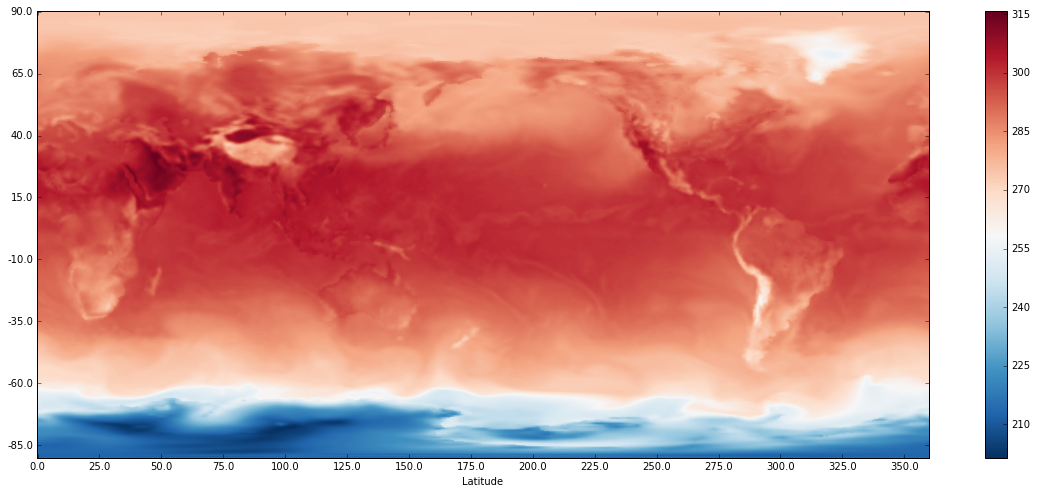

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt;
from ipywidgets import interact
import numpy as np

longitude = np.linspace(0, 360, x.shape[2]).round()
latitude = np.linspace(90, -90, x.shape[1])

@interact(time=[0, x.shape[0] - 1])
def f(time):
    fig = plt.figure(figsize=(20, 8))
    plt.imshow(x[time, : :], cmap='RdBu_r')

    plt.xticks(np.arange(len(longitude))[::100], longitude[::100])
    plt.yticks(np.arange(len(latitude))[::100], latitude[::100])
    plt.xlabel("Longitude")
    plt.xlabel("Latitude")

    plt.colorbar()

Normalize out average behavior
------------------------------

In [10]:
mean = x.mean(axis=0)
std = x.std(axis=0)
z = (x - mean) / std

z = e.persist(z)
progress(z)

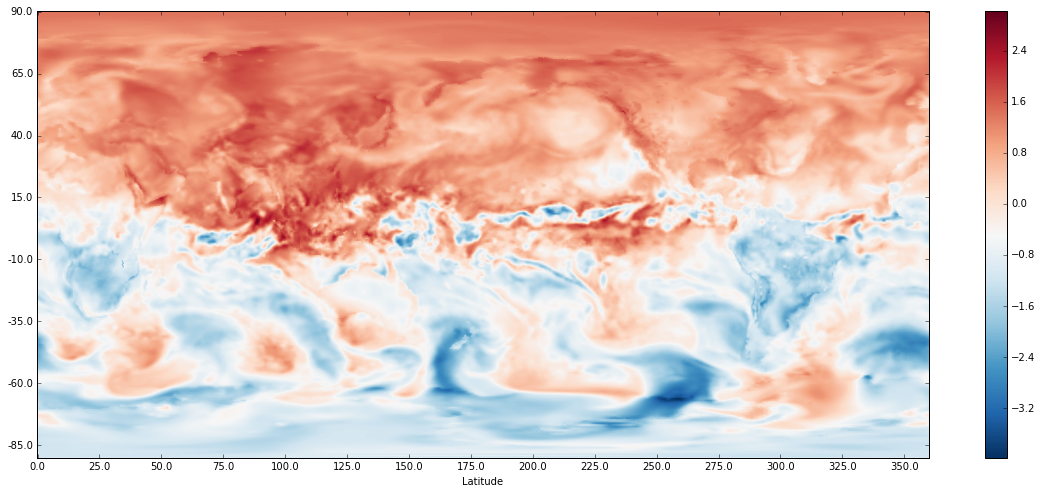

In [11]:
from ipywidgets import interact

@interact(time=[0, z.shape[0] - 1])
def f(time):
    fig = plt.figure(figsize=(20, 8))
    plt.imshow(z[time, : :], cmap='RdBu_r')

    plt.xticks(np.arange(len(longitude))[::100], longitude[::100])
    plt.yticks(np.arange(len(latitude))[::100], latitude[::100])
    plt.xlabel("Longitude")
    plt.xlabel("Latitude")

    plt.colorbar()

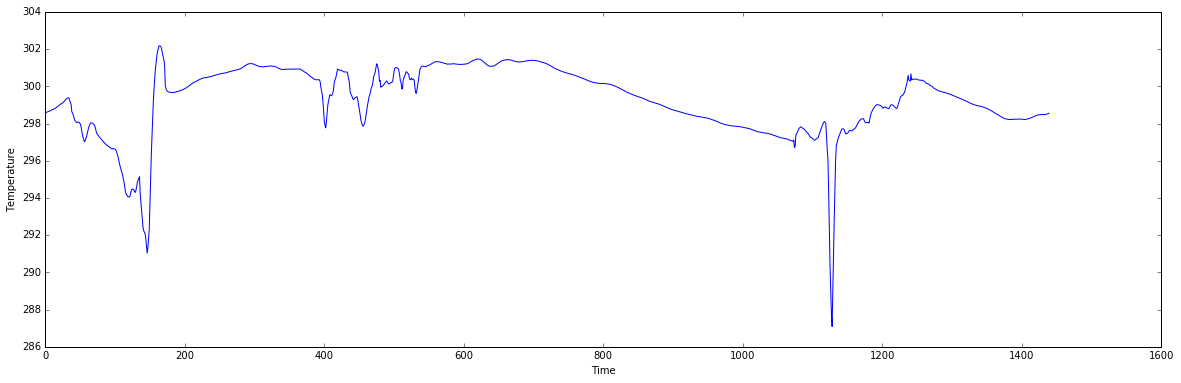

In [12]:
@interact(latitude_index=[0, z.shape[1] - 1])
def f(latitude_index):
    plt.figure(figsize=(20, 6))
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.plot(x[:, latitude_index, :].mean(axis=0))

Low Latency Cluster Computations
--------------------------------

In [13]:
@interact(time=[0, x.shape[0] - 1])
def f(time):
    print("Average Temperature (K):", x[time].mean().compute())

Average Temperature (K): 280.72036471
